# Thailand CO2 emission forecast

The goal of this notebook is to analyse carbon dioxide emission in 1987-2022 in Thailand caused by transport using oil fuel and to make a forecast the value of emission in every month in 2023.<br>
The dataset is taken from https://www.kaggle.com/datasets/thaweewatboy/thailand-carbon-emission-statistics?resource=download<br>
We're going to use the following approaches:
1. Building SARIMAX model.
2. Using Prophet model. 
3. Building a linear regression model based on predictions of previous two models.

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet import Prophet

from scipy.stats import boxcox, ttest_1samp, wilcoxon, norm
from scipy.special import inv_boxcox
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

### Data handling

First of all we need to filter neccessary pollution source and fuel type. We also need to create a date column.

In [46]:
df = pd.read_csv('thailand_co2_emission_1987_2022.csv')
df = df[(df['source'] == 'transport') & (df['fuel_type'] == 'oil')]
df['period'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day': 1})
df = df[['period', 'emissions_tons']]
df.head()

,period,emissions_tons
0,1987-01-01,1588.61
1,1987-02-01,1428.29
2,1987-03-01,1581.16
3,1987-04-01,1557.40
4,1987-05-01,1513.35


Now let's make a graph illustrating the dynamics of the emission value by months.

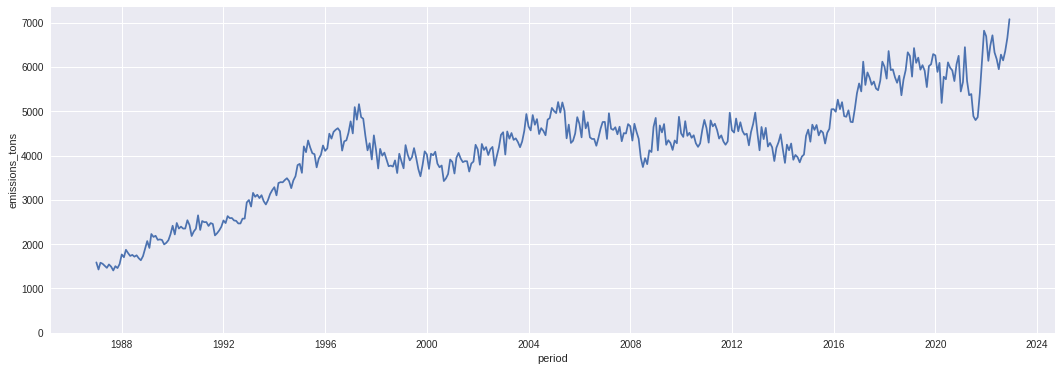

In [47]:
plt.style.use('seaborn')
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x='period', y='emissions_tons')
plt.ylim(0)
plt.show()

### Time series components

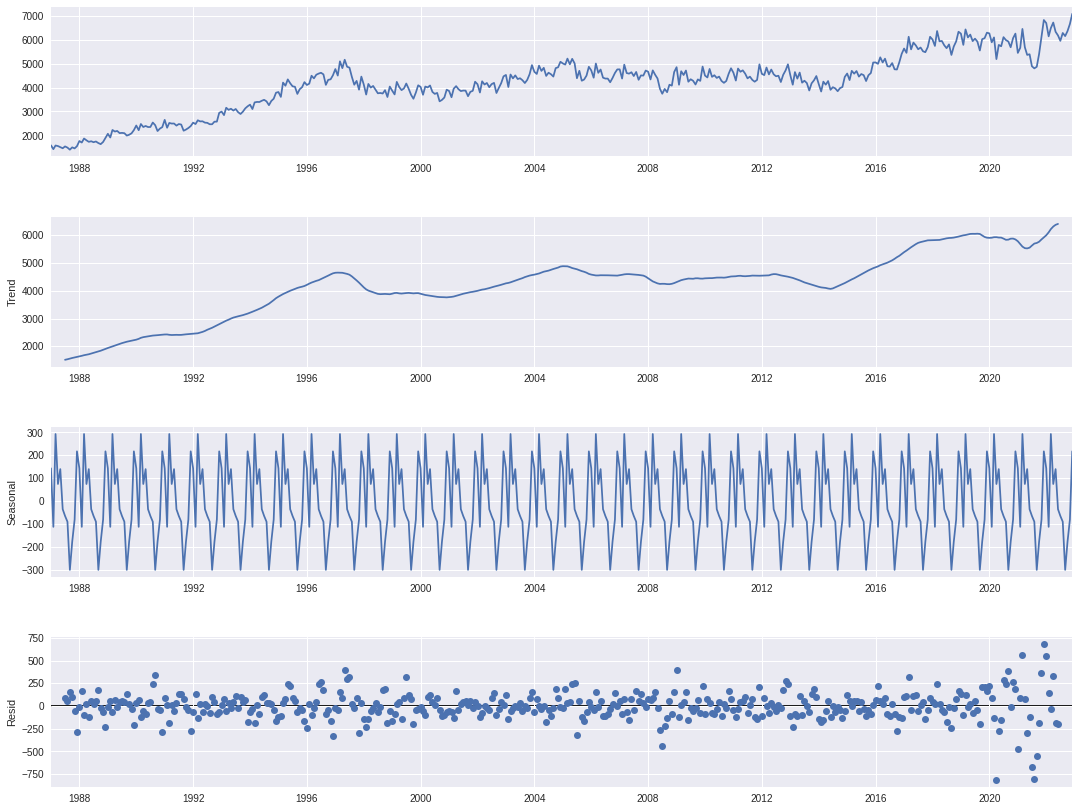

In [48]:
figure = seasonal_decompose(df.set_index('period')).plot()
figure.set_size_inches(16, 12)

The time series has the following features:
<br>- a general increasing trend;
<br>- an annual seasonality pattern;
<br>- increasing fluctuations.

## SARIMAX model

We need to split our time series into train and test. Let's take last 36 months as a test dataset.

In [49]:
train = df.iloc[:-36, :].set_index('period')
test = df.iloc[-36:, :].set_index('period')
train.shape, test.shape

((396, 1), (36, 1))

Now we can implement Box-Cox transformation to stabilize the dispersion.

In [50]:
lmbda = 0
train_transformed = boxcox(train.values.flatten(), lmbda)
train = pd.DataFrame({'emissions_tons_transformed': train_transformed},
                     index=train.index)

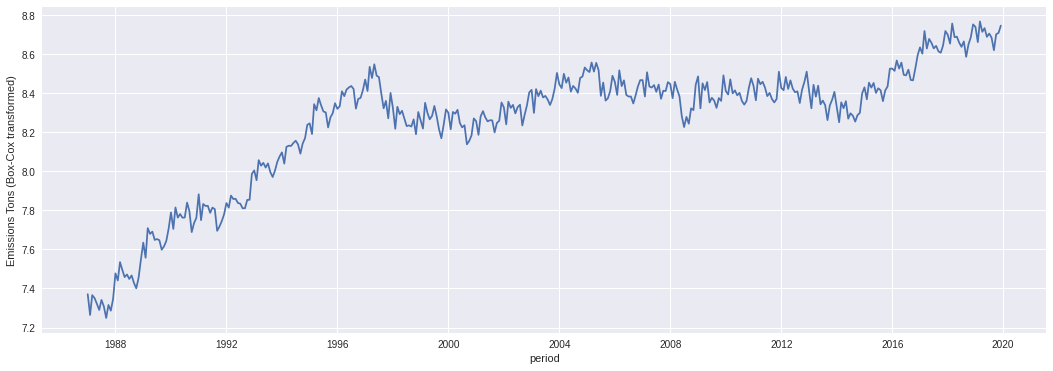

In [51]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=train, x=train.index, y='emissions_tons_transformed')
plt.ylabel('Emissions Tons (Box-Cox transformed)')
plt.show()

The SARIMAX model requires to define the order of the model for the number of AR parameters, differences, and MA parameters as well as the order of seasonal parameters. <br>
To find d-parameter (differences) we should transform our time series into stationary series which has constant mean, variance, and autocorrelation through time. We can use Dickey-Fuller test to find it out.

In [52]:
statistic, p_value = adfuller(train)[:2]
print('statistic:' , statistic)
print('p-value:' , p_value)

statistic: -2.4410096925555584
p-value: 0.13049458216206672


The series is not stationary and needs to be transformed.

In [53]:
difference_1 = train - train.shift(1)
statistic, p_value = adfuller(difference_1.dropna())[:2]
print('statistic:' , statistic)
print('p-value:' , p_value)

statistic: -3.7402778754831263
p-value: 0.0035809872869878834


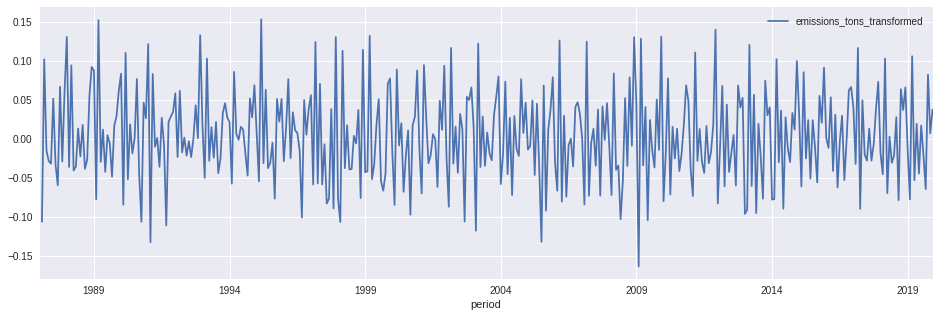

In [54]:
difference_1.plot(figsize=(16, 5))
plt.show()

The first transformation has made our time series stationary so d = 1.<br>
To pick p and q parameters we should make correlograms.

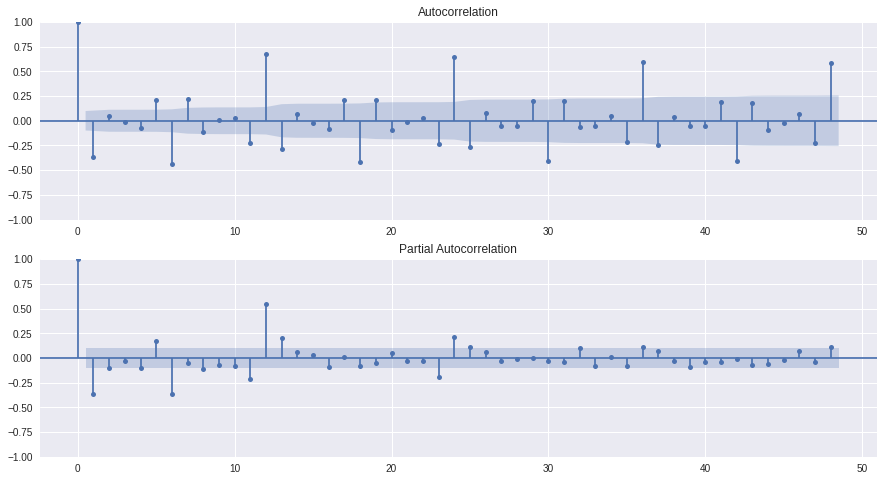

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
plot_acf(difference_1.dropna(), lags=48, ax=ax[0])
plot_pacf(difference_1.dropna(), lags=48, method='ywm', ax=ax[1])
plt.show()

ACF shows the most significant non-seasonal spike at lag 6. The most significant seasonal spike which is multiple of 12 is the first one.<br>
The same approach can also be used to PACF. <br>
Thus let's take the parameters p = 6, d = 1, q = 1, P = 1, D = 1, Q = 1 for our baseline model. 

In [56]:
baseline_model = SARIMAX(train['emissions_tons_transformed'], order=(6, 1, 1), 
                         seasonal_order=(1, 1, 1, 12), freq='MS').fit(disp=False)
baseline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         emissions_tons_transformed   No. Observations:                  396
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 750.423
Date:                            Sat, 13 May 2023   AIC                          -1480.845
Time:                                    18:49:25   BIC                          -1441.365
Sample:                                01-01-1987   HQIC                         -1465.184
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1604      1.258     -0.127      0.899      -2.627       2.306
ar.L2         -0.0653      0.471     -0.138      0.890      -0.989       0.859
ar.L3          0.0227      0.181      0.125      0.900      -0.332       0.377
ar.L4          0.0510      0.053      0.964      0.335      -0.053       0.155
ar.L5          0.0603      0.076      0.791      0.429      -0.089       0.210
ar.L6          0.0293      0.105      0.280      0.780      -0.176       0.235
ma.L1         -0.2142      1.252     -0.171      0.864      -2.667       2.239
ar.S.L12       0.0673      0.064      1.058      0.290      -0.057       0.192
ma.S.L12      -0.8264      0.038    -21.634      0.000      -0.901      -0.752
sigma2         0.0011    7.1e-05     15.851      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                19.55
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's try to find model parameters minimizing AIC value by iterating through the bunch of parameters which can be suitable according to ACF and PACF graphs.

In [57]:
D_param = [0, 1]
p_param = [0, 1, 6]
P_param = [0, 1]
q_param = [0, 1, 6]
Q_param = [0, 1]


best_model = baseline_model
for D in D_param:
    for p in p_param:
        for P in P_param:
            for q in q_param:
                for Q in Q_param:
                    model = SARIMAX(train['emissions_tons_transformed'], order=(1, p, q), 
                                    seasonal_order=(D, P, Q, 12), freq='MS').fit(disp=False)
                    if model.aic < best_model.aic:
                        best_model = model

In [58]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         emissions_tons_transformed   No. Observations:                  396
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 769.020
Date:                            Sat, 13 May 2023   AIC                          -1528.040
Time:                                    18:51:51   BIC                          -1508.145
Sample:                                01-01-1987   HQIC                         -1520.157
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0440      0.125     -0.352      0.725      -0.289       0.201
ma.L1         -0.3236      0.116     -2.790      0.005      -0.551      -0.096
ar.S.L12       0.9888      0.005    201.473      0.000       0.979       0.998
ma.S.L12      -0.7945      0.034    -23.575      0.000      -0.861      -0.728
sigma2         0.0011   6.75e-05     16.750      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.47
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.37
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuals analysis

It is highly import for model validation to check the residuals distribution and to make sure that the residuals:
- are not biased;
- are stationary;
- are not autocorrelated.

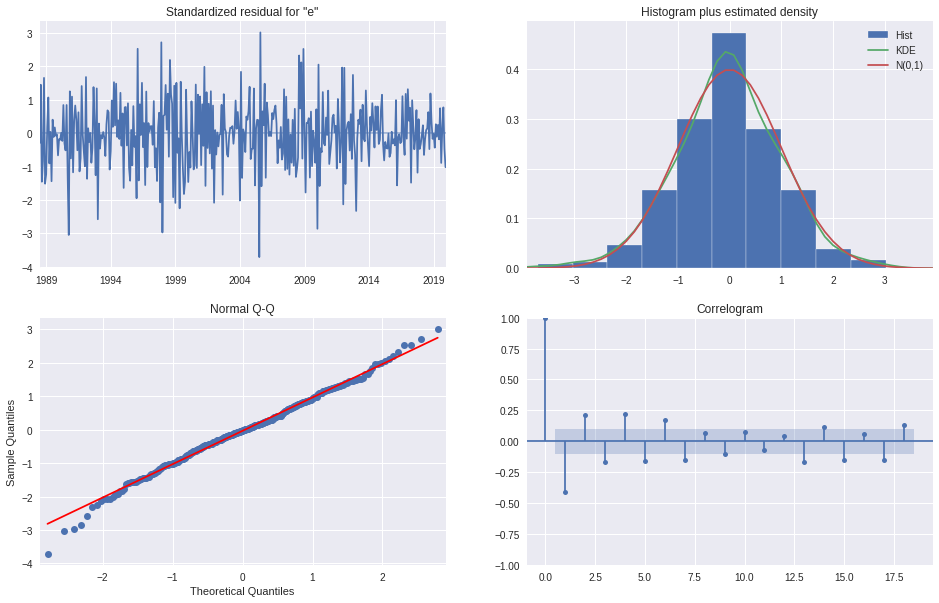

In [59]:
model.plot_diagnostics(figsize=(16, 10), lags=18)
plt.show()

In [60]:
residuals = best_model.resid
wilcoxon(residuals), ttest_1samp(residuals, 0)

(WilcoxonResult(statistic=39125.0, pvalue=0.9377492010780161),
 Ttest_1sampResult(statistic=0.9608549184909472, pvalue=0.33721291822388166))

Both Wilcoxon test and Student's t-test confirm that the residuals are not biased (the average of residuals is approximately equal to 0).
<br>We can check whether the residuals are stationary or not using Dickey-Fuller test as we've done before.

In [61]:
statistic, p_value = adfuller(residuals)[:2]
print('statistic:' , statistic)
print('p-value:' , p_value)

statistic: -215.22593501699515
p-value: 0.0


The test result shows that the residuals are stationary.<br>
Ljung-Box Q-criteria will help us to check if the residuals are not autocorrelated:

In [62]:
acorr_ljungbox(residuals, lags=range(1, 36))

,lb_stat,lb_pvalue
1,0.080646,0.776424
2,0.111906,0.945583
3,0.113444,0.990177
4,0.117426,0.998342
5,0.128620,0.999699
6,0.138222,0.999948
7,0.140262,0.999993
8,0.178491,0.999998
9,0.194020,1.000000
10,0.195239,1.000000


It's all right, the residuals are not autocorrelated.

### Model evaluation

Now we can make a forecast and compare it with the test data. Predicted values should be calculated with Box-Cox inverse transformation.

In [63]:
predictions = inv_boxcox(best_model.forecast(steps=48), lmbda)

In [64]:
sales_lower = inv_boxcox(best_model.get_forecast(48).conf_int(0.05)['lower emissions_tons_transformed'], lmbda)
sales_upper = inv_boxcox(best_model.get_forecast(48).conf_int(0.05)['upper emissions_tons_transformed'], lmbda)

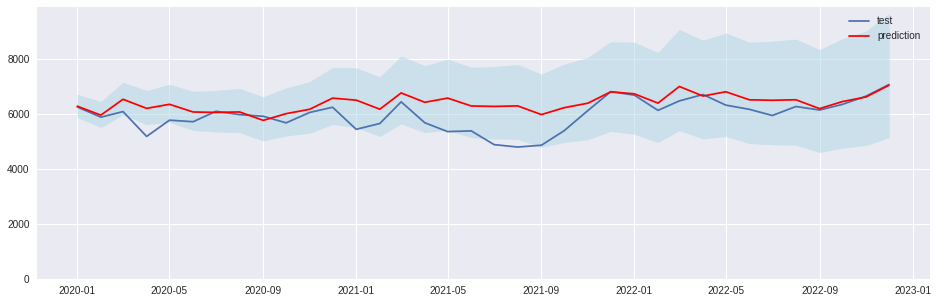

In [65]:
plt.figure(figsize=(16, 5))
plt.grid()
plt.plot(test)
plt.plot(predictions[:36], color='r')
plt.fill_between(test.index, sales_lower[:36], sales_upper[:36], color='lightblue', alpha=0.5)
plt.ylim(0)
plt.legend(['test', 'prediction'])
plt.grid()
plt.show()

As we can see, in general our model copes to predict the emission value. The worst results are observed in the beginning of 2020 and in the middle of 2021. Probably it is connected with the COVID-19 pandemic.<br>
Let's compute mean absolute percentage error to evalute our model:

In [66]:
MAPE(test, predictions[:36])

0.08215381076309876

### SARIMAX 12 months forecast

In [67]:
future_sarimax = predictions[36:]
future_sarimax

2023-01-01    6971.698783
2023-02-01    6626.266389
2023-03-01    7246.072312
2023-04-01    6890.016491
2023-05-01    7049.360607
2023-06-01    6749.269183
2023-07-01    6732.586144
2023-08-01    6750.860464
2023-09-01    6420.727657
2023-10-01    6683.825981
2023-11-01    6855.217568
2023-12-01    7290.382790
Freq: MS, Name: predicted_mean, dtype: float64

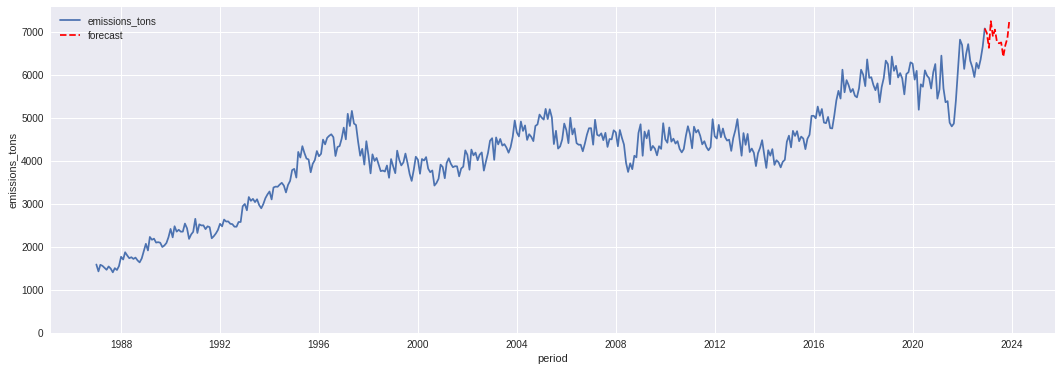

In [68]:
plt.figure(figsize=(18, 6))
sns.lineplot(data=df, x='period', y='emissions_tons', label='emissions_tons')
sns.lineplot(data=df.set_index('period')['emissions_tons'][-1:].append(future_sarimax), 
             label='forecast', 
             color='r', 
             linestyle='--')
plt.ylim(0)
plt.legend()
plt.show()

## Prophet model

For using a Prophet model we should transform our dataframe a little bit and rename the date and the value columns.

In [69]:
df.columns = ['ds', 'y']
train, test = df.iloc[:-36, :], df.iloc[-36:, :]

In [70]:
model = Prophet(interval_width=0.95)
model.fit(train)
future = model.make_future_dataframe(periods=48, freq='MS')
forecast = model.predict(future)

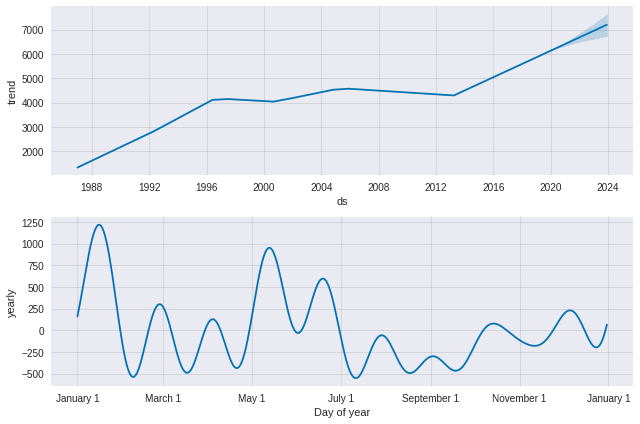

In [71]:
model.plot_components(forecast)
plt.show()

The Prophet has caught an upward trend and an annual cycle in our time series.

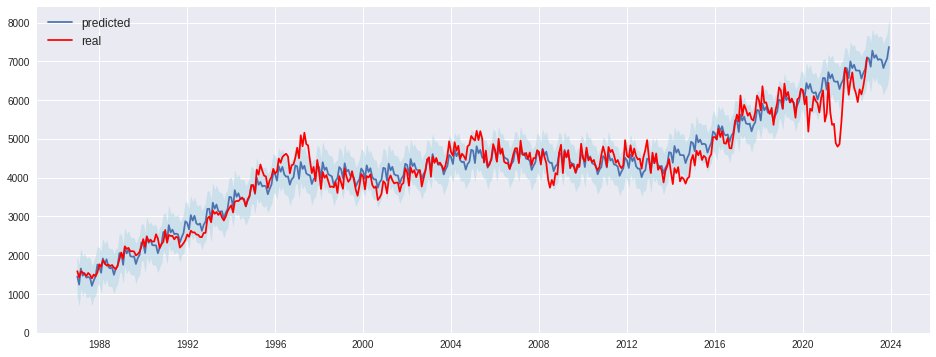

In [72]:
plt.figure(figsize=(16, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='predicted')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.5)
plt.plot(df['ds'], df['y'], color='red', label='real')
plt.ylim(0)
plt.legend(prop={'size': 12})
plt.show()

Now lets's evaluate our baseline Prophet model using MAPE:

In [73]:
predictions = forecast['yhat'][-48:-12]
score = MAPE(test['y'], predictions)
score

0.10135776927574602

### Prophet model tuning

In [74]:
params_grid = {  
     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5], 
     'seasonality_prior_scale': [0.01, 0.08, 1.0, 10.0], 
     'seasonality_mode': ['multiplicative', 'additive'],
     'growth': ['linear', 'logistic']
}

grid = ParameterGrid(params_grid)
best_param = dict()
best_score = score
best_forecast = pd.DataFrame()

for param in tqdm(grid):
    try:
        model = Prophet(**param, interval_width=0.95).fit(train)
        future = model.make_future_dataframe(periods=48, freq='MS')
        forecast = model.predict(future)
        predictions = forecast['yhat'][-48:-12]
        if MAPE(test['y'], predictions) < best_score:
            best_score = MAPE(test['y'], predictions)
            best_param = param
            best_forecast = forecast
    except ValueError:
        continue

  0%|          | 0/64 [00:00<?, ?it/s]

In [75]:
best_param

{'changepoint_prior_scale': 0.001,
 'growth': 'linear',
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10.0}

After we got the best Prophet parameters we can estimate the performance of the model.

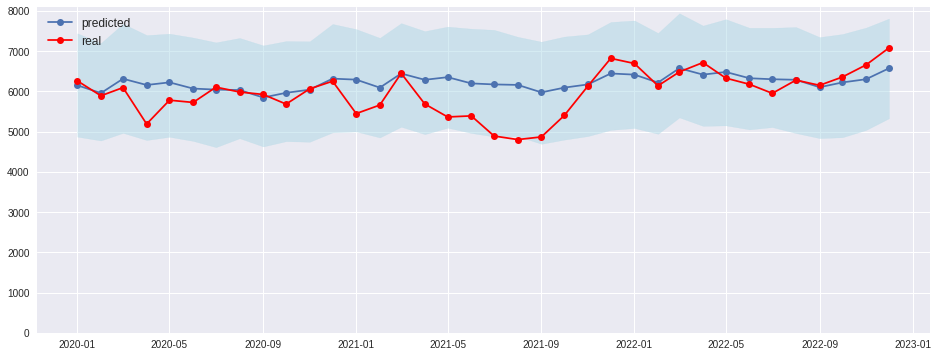

In [76]:
predicted = best_forecast[-48:-12]

plt.figure(figsize=(16, 6))
plt.plot(predicted['ds'], predicted['yhat'], label='predicted', marker='o')
plt.fill_between(predicted['ds'], predicted['yhat_lower'], predicted['yhat_upper'], color='lightblue', alpha=0.5)
plt.plot(test['ds'], test['y'], color='red', label='real', marker='o')
plt.ylim(0)
plt.legend(prop={'size': 12})
plt.show()

In [77]:
predicted = test.merge(predicted[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
predicted['error'] = predicted['yhat'] - predicted['y']
predicted['percent_error'] = (predicted['yhat'] - predicted['y']) / predicted['y'] * 100
predicted.iloc[:, 1:] = np.around(predicted.iloc[:, 1:], 2)
predicted

,ds,y,yhat,yhat_lower,yhat_upper,error,percent_error
0,2020-01-01,6259.42,6148.49,4872.39,7439.01,-110.93,-1.77
1,2020-02-01,5887.56,5954.32,4776.72,7197.10,66.76,1.13
2,2020-03-01,6091.05,6310.14,4966.49,7677.17,219.09,3.60
3,2020-04-01,5186.49,6155.39,4788.79,7394.06,968.90,18.68
4,2020-05-01,5777.98,6220.60,4868.65,7430.22,442.62,7.66
5,2020-06-01,5722.02,6066.56,4766.88,7333.11,344.54,6.02
6,2020-07-01,6102.24,6040.85,4611.99,7213.60,-61.39,-1.01
7,2020-08-01,5980.50,6030.18,4833.55,7323.30,49.68,0.83
8,2020-09-01,5920.29,5844.14,4628.53,7137.68,-76.15,-1.29
9,2020-10-01,5680.79,5960.73,4760.73,7246.34,279.94,4.93


In [78]:
print(f'Mean average percentage error: {100 * best_score:.2f}%')

Mean average percentage error: 6.92%


### Prophet model 12 months forecast

In [79]:
future_prophet = best_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:]
future_prophet.iloc[:, 1:] = np.around(future_prophet.iloc[:, 1:], 2)
future_prophet

,ds,yhat,yhat_lower,yhat_upper
432,2023-01-01,6537.33,5233.20,7738.34
433,2023-02-01,6341.42,5064.89,7578.65
434,2023-03-01,6701.92,5424.72,7960.10
435,2023-04-01,6541.73,5248.48,7828.19
436,2023-05-01,6607.70,5171.34,7892.64
437,2023-06-01,6451.37,5077.42,7657.46
438,2023-07-01,6426.89,5205.29,7760.98
439,2023-08-01,6412.12,5117.06,7737.83
440,2023-09-01,6227.46,5034.60,7459.61
441,2023-10-01,6348.08,5013.82,7563.27


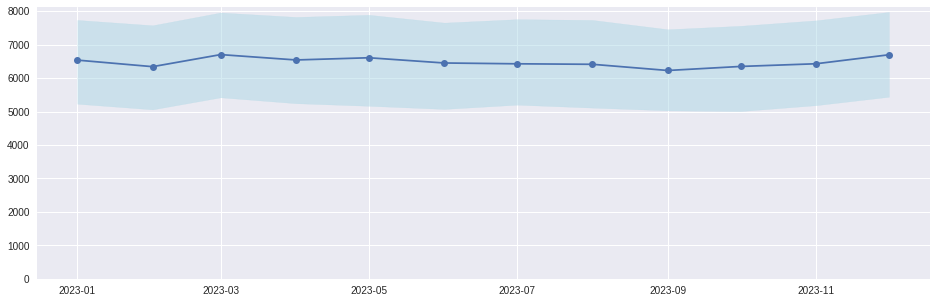

In [80]:
plt.figure(figsize=(16, 5))
plt.plot(future_prophet['ds'], future_prophet['yhat'], marker='o')
plt.fill_between(future_prophet['ds'], 
                 future_prophet['yhat_lower'], 
                 future_prophet['yhat_upper'], 
                 color='lightblue', 
                 alpha=0.5)
plt.ylim(0)
plt.show()

## Linear regression based on two models' predictions

Let's take both models' train predictions and make the final forecast using a linear regression model. 

In [81]:
res_train = pd.DataFrame({'sarimax': inv_boxcox(best_model.predict(start=1, end=395), lmbda).reset_index(drop=True),
                          'prophet': best_forecast[1:-48].reset_index(drop=True)['yhat'],
                          'y': train['y'][1:].reset_index(drop=True)})

In [82]:
sarimax_test = inv_boxcox(best_model.predict(start=396, end=431), lmbda).reset_index(drop=True)
prophet_test = best_forecast[-48:-12].reset_index(drop=True)['yhat']

res_test = pd.DataFrame({'sarimax': sarimax_test,
                          'prophet': prophet_test,
                          'y': test['y'].reset_index(drop=True)})

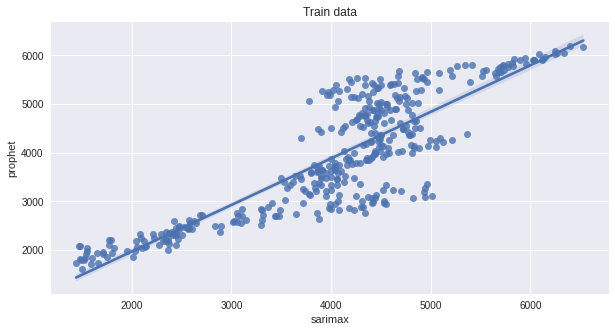

In [83]:
plt.figure(figsize=(10, 5))
sns.regplot(res_train['sarimax'], res_train['prophet'])
plt.title('Train data')
plt.show()

In [84]:
regression = LinearRegression()
regression.fit(res_train[['sarimax', 'prophet']], res_train['y'])
y_pred = regression.predict(res_test[['sarimax', 'prophet']])
MAPE(res_test['y'], y_pred)

0.07963150085831643

In [85]:
stdev = np.std(y_pred, ddof=0)
yhat_low, yhat_high = norm.ppf(0.025) * stdev, norm.ppf(0.975) * stdev

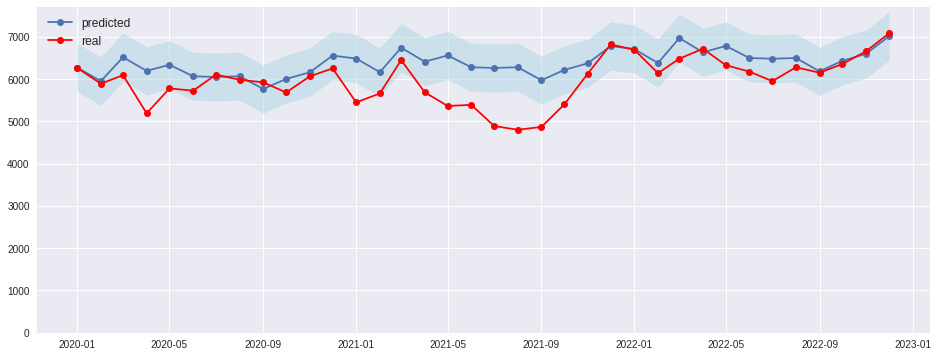

In [86]:
plt.figure(figsize=(16, 6))
plt.plot(predicted['ds'], y_pred, label='predicted', marker='o')
plt.fill_between(predicted['ds'], y_pred + yhat_low, y_pred + yhat_high, color='lightblue', alpha=0.5)
plt.plot(test['ds'], test['y'], color='red', label='real', marker='o')
plt.ylim(0)
plt.legend(prop={'size': 12})
plt.show()

Linear regression model coefficients:

In [87]:
regression.coef_, regression.intercept_

(array([0.94942791, 0.04356296]), 29.76532082799622)

### Linear regression 12 months forecast

In [88]:
regression_forecast = pd.DataFrame({'sarimax': future_sarimax.reset_index(drop=True),
                                    'prophet': best_forecast['yhat'][-12:].reset_index(drop=True)})
regression_forecast['regression'] = regression_forecast['sarimax'] * regression.coef_[0] + \
                                    regression_forecast['prophet'] * regression.coef_[1] + \
                                    regression.intercept_
regression_forecast.index = future_sarimax.index
regression_forecast

,sarimax,prophet,regression
2023-01-01,6971.698783,6537.334025,6933.676384
2023-02-01,6626.266389,6341.422547,6597.178742
2023-03-01,7246.072312,6701.915326,7201.343920
2023-04-01,6890.016491,6541.733318,6856.316583
2023-05-01,7049.360607,6607.701164,7010.476088
2023-06-01,6749.269183,6451.369953,6718.750664
2023-07-01,6732.586144,6426.885017,6701.844685
2023-08-01,6750.860464,6412.124702,6718.551831
2023-09-01,6420.727657,6227.463118,6397.070123
2023-10-01,6683.825981,6348.075781,6652.117261


## Conclusion

The best performing model was Prophet with tuned parameters. The mean average percentage error is less than 7%. <br>
The most significant deviations from the test data are in the beginning of 2020 and in the middle of 2021. It can be explained by restriction measures to slow the spread of COVID-19. Predictions for other periods are quite accurate.